In [1]:
## Our standard imports
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

## Models & evaluation metrics
from sklearn import metrics
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',50)

# set text displays for sklearn
from sklearn import set_config
set_config(display='text')

In [2]:
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model'):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

In [3]:
Sales_P = pd.read_csv(r"Data/sales_predictions_2023.csv")
Sales_P.head()

Item_Identifier  Item_Weight Item_Fat_Content  Item_Visibility  \
0           FDA15         9.30          Low Fat         0.016047   
1           DRC01         5.92          Regular         0.019278   
2           FDN15        17.50          Low Fat         0.016760   
3           FDX07        19.20          Regular         0.000000   
4           NCD19         8.93          Low Fat         0.000000   

               Item_Type  Item_MRP Outlet_Identifier  \
0                  Dairy  249.8092            OUT049   
1            Soft Drinks   48.2692            OUT018   
2                   Meat  141.6180            OUT049   
3  Fruits and Vegetables  182.0950            OUT010   
4              Household   53.8614            OUT013   

   Outlet_Establishment_Year Outlet_Size Outlet_Location_Type  \
0                       1999      Medium               Tier 1   
1                       2009      Medium               Tier 3   
2                       1999      Medium               Tier 1   
3                       1998         NaN               Tier 3   
4                       1987        High               Tier 3   

         Outlet_Type  Item_Outlet_Sales  
0  Supermarket Type1          3735.1380  
1  Supermarket Type2           443.4228  
2  Supermarket Type1          2097.2700  
3      Grocery Store           732.3800  
4  Supermarket Type1           994.7052

In [4]:
Sales_P.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [5]:
#No duplicate data to drop
Sales_P.duplicated().sum()

0

In [6]:
Sales_P.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [7]:
# Replaced the Ordinal features
Sales_P['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [8]:
replacement_dictionary= {'Low Fat':0,'LF':0,'low fat':0,'Regular':1,'reg':1}
Sales_P['Item_Fat_Content'].replace(replacement_dictionary, inplace= True)
Sales_P['Item_Fat_Content']

0       0
1       1
2       0
3       1
4       0
       ..
8518    0
8519    1
8520    0
8521    1
8522    0
Name: Item_Fat_Content, Length: 8523, dtype: int64

In [9]:
Sales_P['Item_Fat_Content'].value_counts()

0    5517
1    3006
Name: Item_Fat_Content, dtype: int64

I droped the column because it would produce a really long one hot encoder and I was told to do so by the assingment.

In [10]:
del Sales_P['Item_Identifier']
del Sales_P['Outlet_Identifier']

In [11]:
Sales_P.describe()

Item_Weight  Item_Fat_Content  Item_Visibility     Item_MRP  \
count  7060.000000       8523.000000      8523.000000  8523.000000   
mean     12.857645          0.352693         0.066132   140.992782   
std       4.643456          0.477836         0.051598    62.275067   
min       4.555000          0.000000         0.000000    31.290000   
25%       8.773750          0.000000         0.026989    93.826500   
50%      12.600000          0.000000         0.053931   143.012800   
75%      16.850000          1.000000         0.094585   185.643700   
max      21.350000          1.000000         0.328391   266.888400   

       Outlet_Establishment_Year  Item_Outlet_Sales  
count                8523.000000        8523.000000  
mean                 1997.831867        2181.288914  
std                     8.371760        1706.499616  
min                  1985.000000          33.290000  
25%                  1987.000000         834.247400  
50%                  1999.000000        1794.331000  
75%                  2004.000000        3101.296400  
max                  2009.000000       13086.964800

# Part 3

In [12]:
sns.set(rc={'figure.figsize':(30,10)})
sns.histplot(data=Sales_P,x='Item_Weight',y='Item_Outlet_Sales')
plt.show()

Boxplot to view statistical summaries of various features in your dataset.

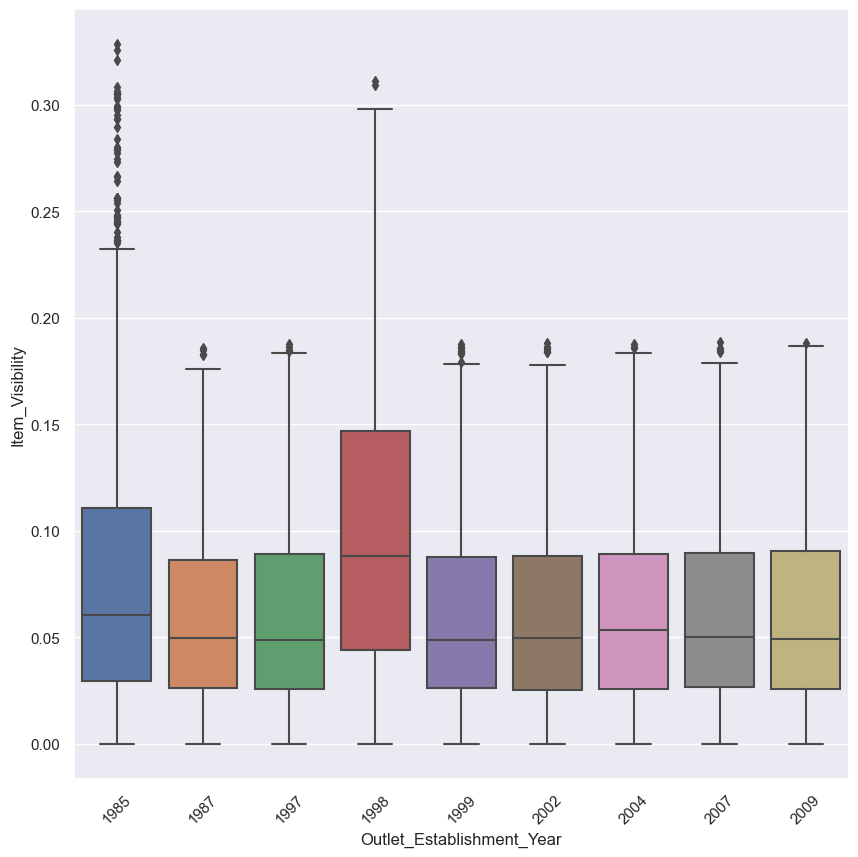

In [13]:
sns.set(rc={'figure.figsize':(10,10)})
plt.xticks(rotation=45)
sns.boxplot(data=Sales_P, x='Outlet_Establishment_Year', y= 'Item_Visibility')  
plt.show()

Heatmap of the correlation between features.

C:\Users\miran\AppData\Local\Temp\ipykernel_29668\3681481867.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(Sales_P.corr(),annot=True,cmap='Blues');


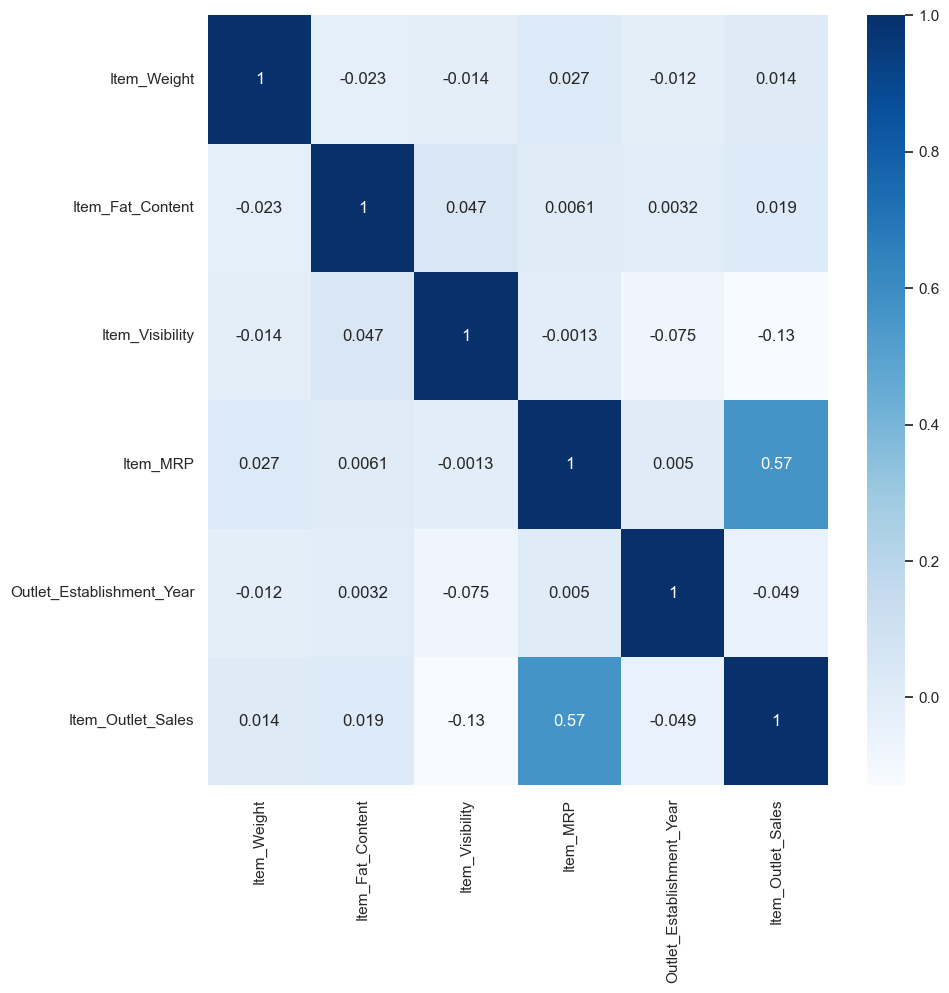

In [14]:
sns.heatmap(Sales_P.corr(),annot=True,cmap='Blues');


# Part 4

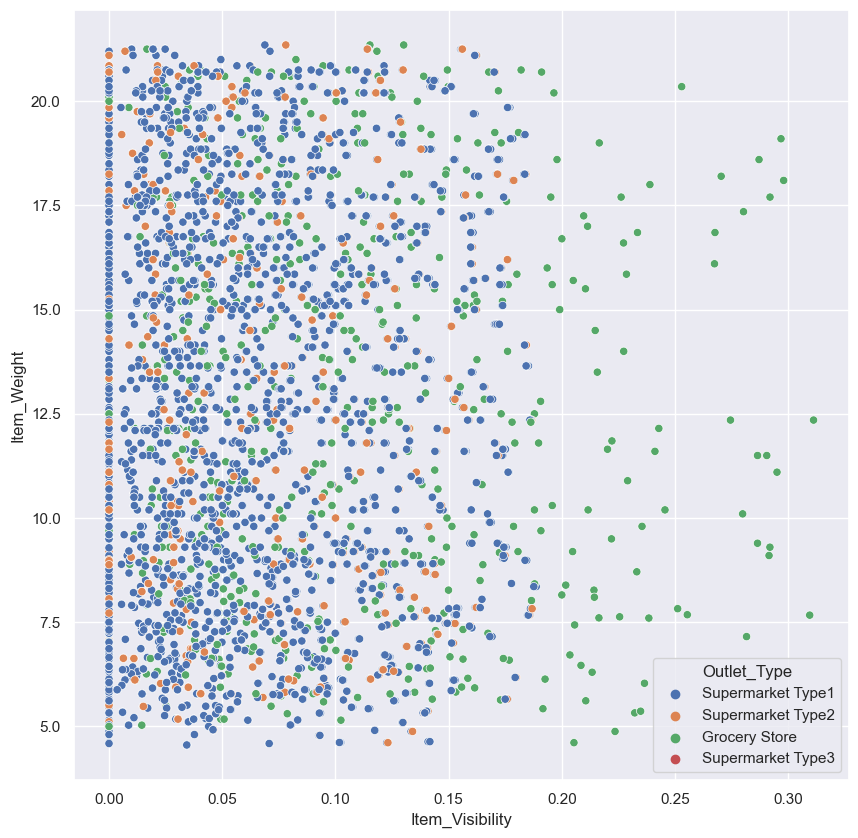

In [15]:
sns.scatterplot(data= Sales_P, x='Item_Visibility', y='Item_Weight', hue= 'Outlet_Type');
# this scatterplot show that the visibility is very importtant in Grocery stores.

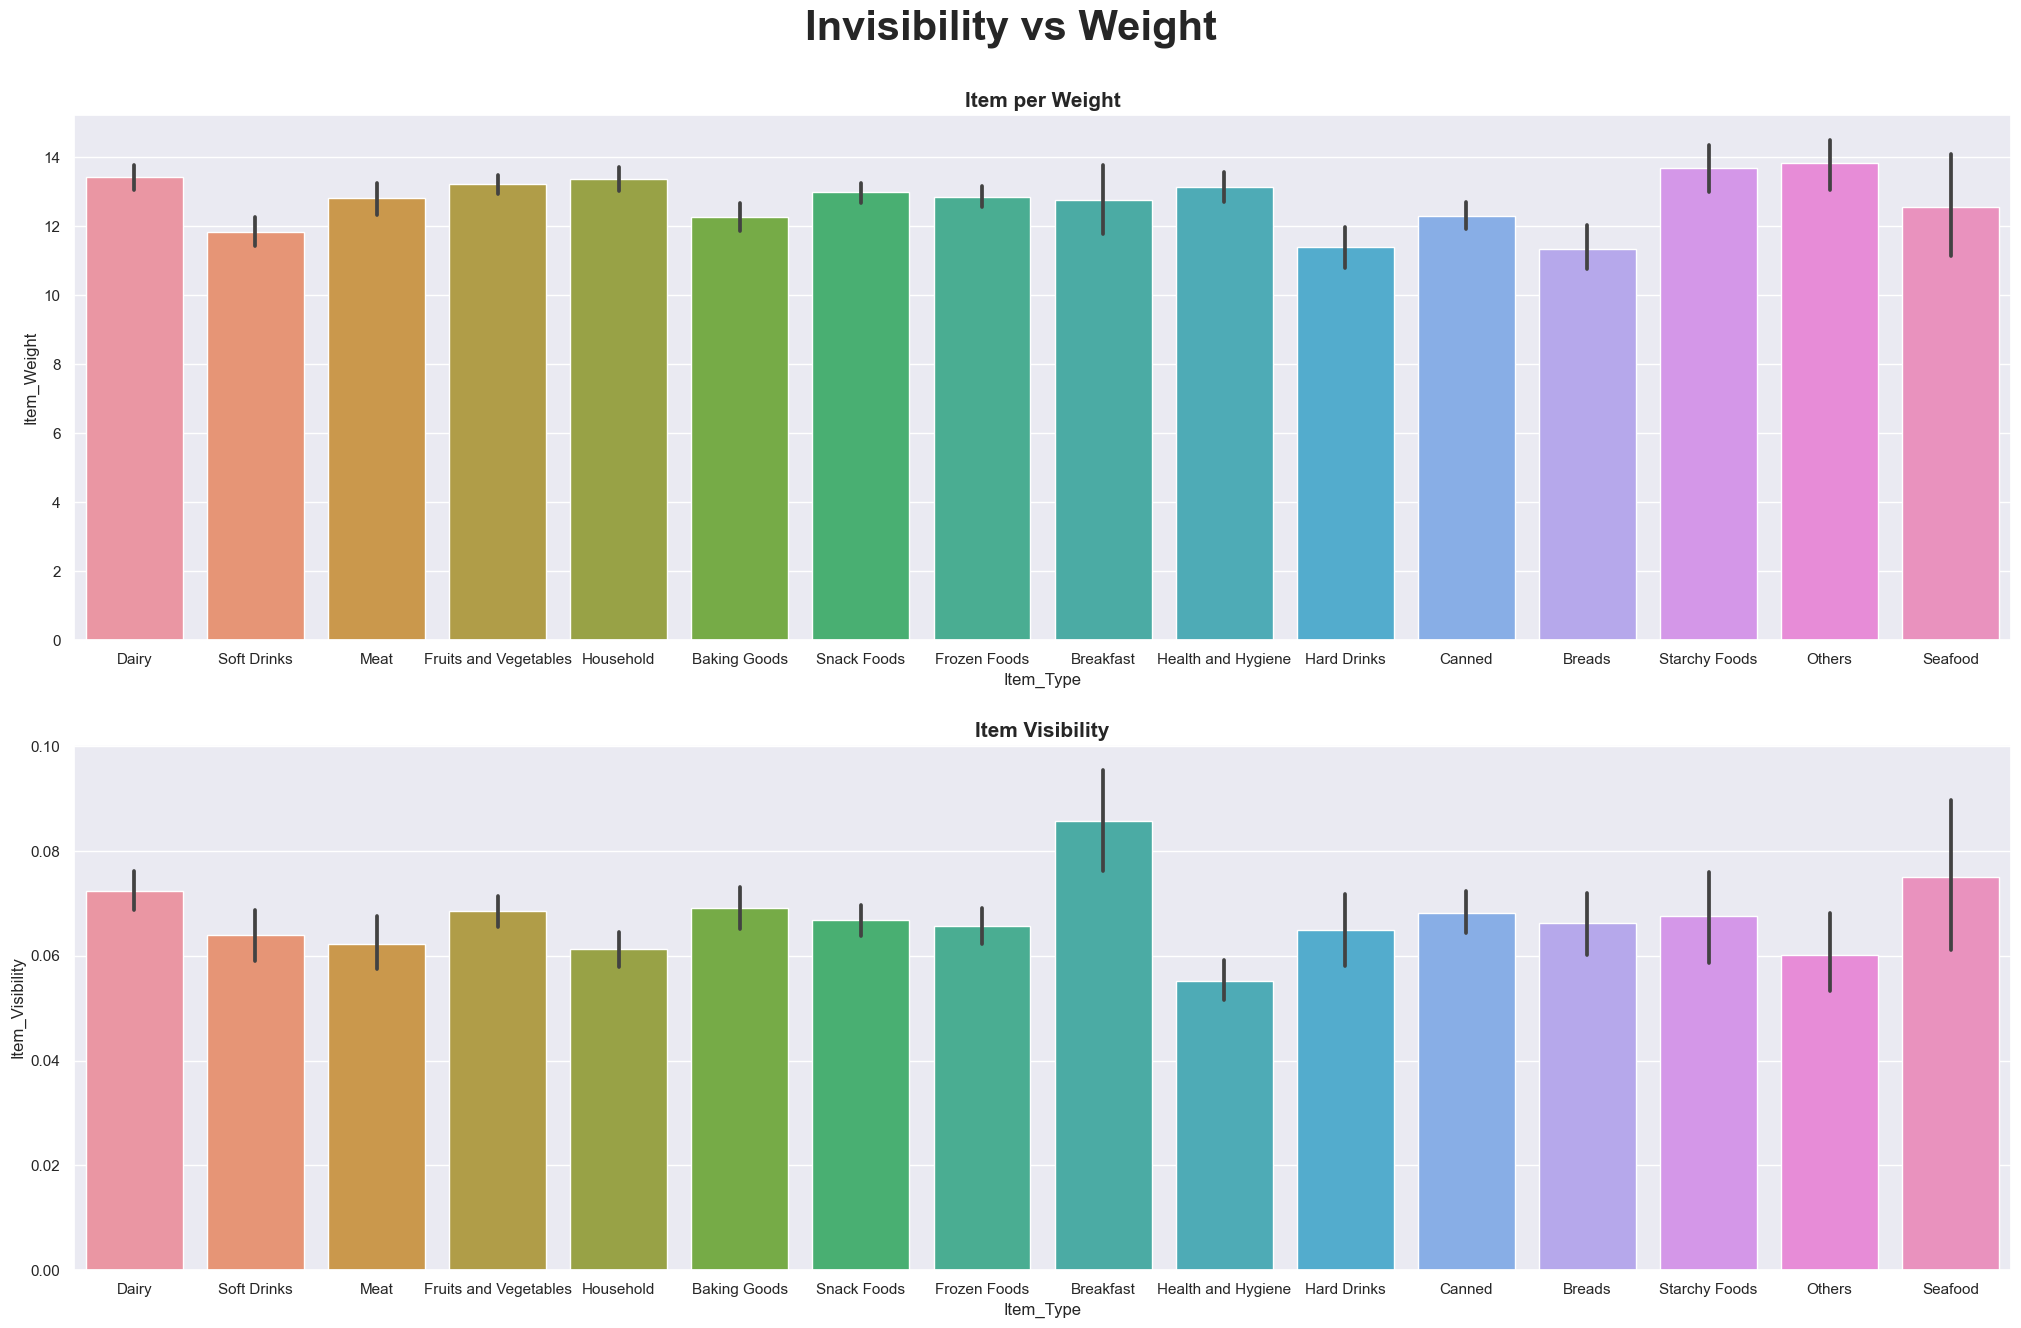

In [16]:
fig, axes = plt.subplots(nrows = 2, figsize = (25,15))

sns.barplot(data = Sales_P, x = 'Item_Type', y= 'Item_Weight', ax = axes[0])
axes[0].set_title('Item per Weight', fontsize = 15, fontweight = 'bold')


sns.barplot(data = Sales_P, x = 'Item_Type', y = 'Item_Visibility', ax = axes[1])
axes[1].set_title('Item Visibility', fontsize = 15, fontweight = 'bold')


fig.suptitle('Invisibility vs Weight', fontsize = 30, fontweight = 'bold', y = .95);

# I was trying to find a correlation between the wight and the visibility of an item but I don't see much difference between both bar graphs beneath.

# Part 5
Identify the features (X) and target (y)

In [17]:
# Identified the X and Y made the split
X= Sales_P.drop('Item_Outlet_Sales', axis=1)
y= Sales_P['Item_Outlet_Sales']

#split performed
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = SEED) 

In [18]:
## make categorical selector and verify it works
cat_sel= make_column_selector(dtype_include='object')
cat_pipe= make_pipeline(SimpleImputer(strategy='constant', fill_value='MISSING'),
                        OneHotEncoder(handle_unknown='ignore', sparse=False))
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [19]:
## make numeric selector and verify it works
num_sel= make_column_selector(dtype_include='number')
num_pipe= make_pipeline(SimpleImputer(strategy='mean'))
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer())])

In [20]:
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe, cat_sel),
                                       verbose_feature_names_out=False)
preprocessor

ColumnTransformer(transformers=[('pipeline-1',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B05CCED8B0>),
                                ('pipeline-2',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000001B05CCE9FD0>)],
                  verbose_feature_names_out=

In [21]:
## fit column transformer and get_feature_names_out
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
8269     7.220000               1.0         0.064142   61.2510   
7604     6.135000               0.0         0.079294  111.2860   
2762    12.150000               0.0         0.028593  151.0708   
6464     5.945000               0.0         0.093009  127.8652   
4707    18.200000               1.0         0.066285  247.2092   
...           ...               ...              ...       ...   
3482    12.822634               0.0         0.012216  162.7894   
8360    11.500000               0.0         0.014884  174.5080   
5929     5.110000               0.0         0.034945  161.1210   
4220     6.550000               1.0         0.034800  157.5288   
6682     7.810000               0.0         0.067730  242.6486   

      Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
8269                     1998.0                     1.0               0.0   
7604                     2009.0                     0.0               0.0   
2762                     2004.0                     0.0               0.0   
6464                     2004.0                     0.0               0.0   
4707                     2004.0                     0.0               0.0   
...                         ...                     ...               ...   
3482                     1985.0                     0.0               0.0   
8360                     1999.0                     0.0               0.0   
5929                     2002.0                     0.0               0.0   
4220                     2007.0                     0.0               1.0   
6682                     2009.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
8269                  0.0               0.0              0.0   
7604                  0.0               0.0              0.0   
2762                  0.0               0.0              0.0   
6464                  0.0               0.0              0.0   
4707                  0.0               0.0              0.0   
...                   ...               ...              ...   
3482                  0.0               0.0              0.0   
8360                  0.0               0.0              0.0   
5929                  0.0               0.0              0.0   
4220                  0.0               0.0              0.0   
6682                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
8269                     0.0                              0.0   
7604                     0.0                              0.0   
2762                     0.0                              0.0   
6464                     0.0                              0.0   
4707                     0.0                              1.0   
...                      ...                              ...   
3482                     0.0                              1.0   
8360                     0.0                              0.0   
5929                     0.0                              0.0   
4220                     0.0                              0.0   
6682                     0.0                              0.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
8269                    0.0                           0.0   
7604                    0.0                           0.0   
2762                    0.0                           0.0   
6464                    0.0                           0.0   
4707                    0.0                           0.0   
...                     ...                           ...   
3482                    0.0                           0.0   
8360                    0.0                           0.0   
5929                    0.0                           0.0   
4220                    0.0                           0.0   
6682                    0.0                           0.0   

     

In [22]:
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
# Check for missing values and that data is scaled and one-hot encoded
print(np.isnan(X_train_processed).sum().sum(), 'missing values in training data')
print(np.isnan(X_test_processed).sum().sum(), 'missing values in testing data')
print('\n')
print('All data in X_train_processed are', X_train_processed.dtype)
print('All data in X_test_processed are', X_test_processed.dtype)
print('\n')
print('shape of data is', X_train_processed.shape)
print('\n')
X_train_processed[:5]

0 missing values in training data
0 missing values in testing data


All data in X_train_processed are float64
All data in X_test_processed are float64


shape of data is (6392, 32)




array([[7.2200000e+00, 1.0000000e+00, 6.4141866e-02, 6.1251000e+01,
        1.9980000e+03, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [6.1350000e+00, 0.0000000e+00, 7.9293753e-02, 1.1128600e+02,
        2.0090000e+03, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000

## Linear Regression

In [23]:
reg = LinearRegression()
reg_pipe = make_pipeline(preprocessor, reg)
reg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B05CCED8B0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                          

In [24]:
model_metrics(reg_pipe, X_train, y_train, X_test, y_test, model_name='Linear Regression Model')

Linear Regression Model Train Scores
MAE: 826.7863 
MSE: 1,243,176.4889 
RMSE: 1,114.9782 
R2: 0.5640

Linear Regression Model Test Scores
MAE: 859.9714 
MSE: 1,355,858.3137 
RMSE: 1,164.4133 
R2: 0.5605



In [25]:
train_score = reg_pipe.score(X_train, y_train)
test_score = reg_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

0.5639622949371432
0.56046732460325


## Decision Tree

In [26]:
reg_tree = DecisionTreeRegressor(random_state= 42)
dec_pipe = make_pipeline(preprocessor, reg_tree)
dec_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x000001B05CCED8B0>),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='MISSING',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                          

In [27]:
train_preds = dec_pipe.predict(X_train)
test_preds = dec_pipe.predict(X_test)

In [28]:
depths = range(1, dec_pipe['decisiontreeregressor'].get_depth())

#create a dataframe to store train and test scores.
scores = pd.DataFrame(columns=['Train', 'Test'], index=depths)

#loop over the values in depths
for n in depths:
  #fit a new model with max_depth
  tree = DecisionTreeRegressor(random_state = SEED, max_depth=n)

  #put the model into a pipeline
  tree_pipe = make_pipeline(preprocessor, tree)
  
  #fit the model
  tree_pipe.fit(X_train, y_train)
  
  #create prediction arrays
  train_pred = tree_pipe.predict(X_train)
  test_pred = tree_pipe.predict(X_test)
  
  #evaluate the model using R2 Score
  train_r2score = r2_score(y_train, train_pred)
  test_r2score = r2_score(y_test, test_pred)
  
  #store the scores in the scores dataframe
  scores.loc[n, 'Train'] = train_r2score
  scores.loc[n, 'Test'] = test_r2score

In [29]:
scores

Train      Test
1   0.235878  0.235114
2   0.434453  0.425721
3    0.52507  0.522549
4   0.585098  0.581303
5   0.605795  0.590751
6   0.617984  0.589241
7   0.630596  0.574912
8   0.649501  0.555426
9   0.672717  0.542738
10  0.697018  0.523149
11  0.721852  0.495278
12  0.749278  0.461376
13   0.77963  0.419297
14  0.807003  0.393427
15  0.836181  0.347205
16  0.861165  0.300404
17  0.883512  0.296938
18  0.906584  0.256754
19   0.92685  0.257822
20  0.942918  0.231303
21  0.955141   0.23818
22  0.967566  0.191659
23  0.978583  0.214983
24  0.986325  0.192035
25  0.992081  0.173849
26  0.995576  0.198346
27  0.997778  0.192688
28  0.998941  0.166288
29   0.99933  0.168422
30  0.999445  0.191591
31  0.999559  0.175071
32  0.999693  0.183752
33   0.99984  0.182934
34  0.999903  0.165348
35  0.999945  0.172107
36  0.999969  0.178197
37  0.999986  0.177027
38  0.999997  0.163423
39       1.0  0.155663
40       1.0   0.16046

In [30]:
plt.plot(depths, scores['Train'], label = 'train')
plt.plot(depths, scores['Test'], label = 'test')
plt.ylabel('R2 Scores')
plt.xlabel('Max Depths')
plt.legend()
plt.show()

In [31]:
best_depth = scores.sort_values(by='Test', ascending=False).index[0]
best_depth

5

In [32]:
best_tree = DecisionTreeRegressor(random_state = SEED, max_depth=best_depth)

best_tree_pipe = make_pipeline(preprocessor, best_tree)

best_tree_pipe.fit(X_train, y_train)

model_metrics(best_tree_pipe, X_train, y_train, X_test, y_test, model_name='Decision Regression Model')

Decision Regression Model Train Scores
MAE: 742.5054 
MSE: 1,123,906.9622 
RMSE: 1,060.1448 
R2: 0.6058

Decision Regression Model Test Scores
MAE: 797.2464 
MSE: 1,262,440.0763 
RMSE: 1,123.5836 
R2: 0.5908



In [33]:
train_score = dec_pipe.score(X_train, y_train)
test_score = dec_pipe.score(X_test, y_test)
print(train_score)
print(test_score)

1.0
0.16360269217470658


### Overall, which model do you recommend?
I would recommend using the decision regression tree. It has a low bias and variance and the testing dta is higher. This is done through tuning.

I added these to make the visualization make since to me.

<AxesSubplot: xlabel='Item_Visibility', ylabel='Item_Outlet_Sales'>

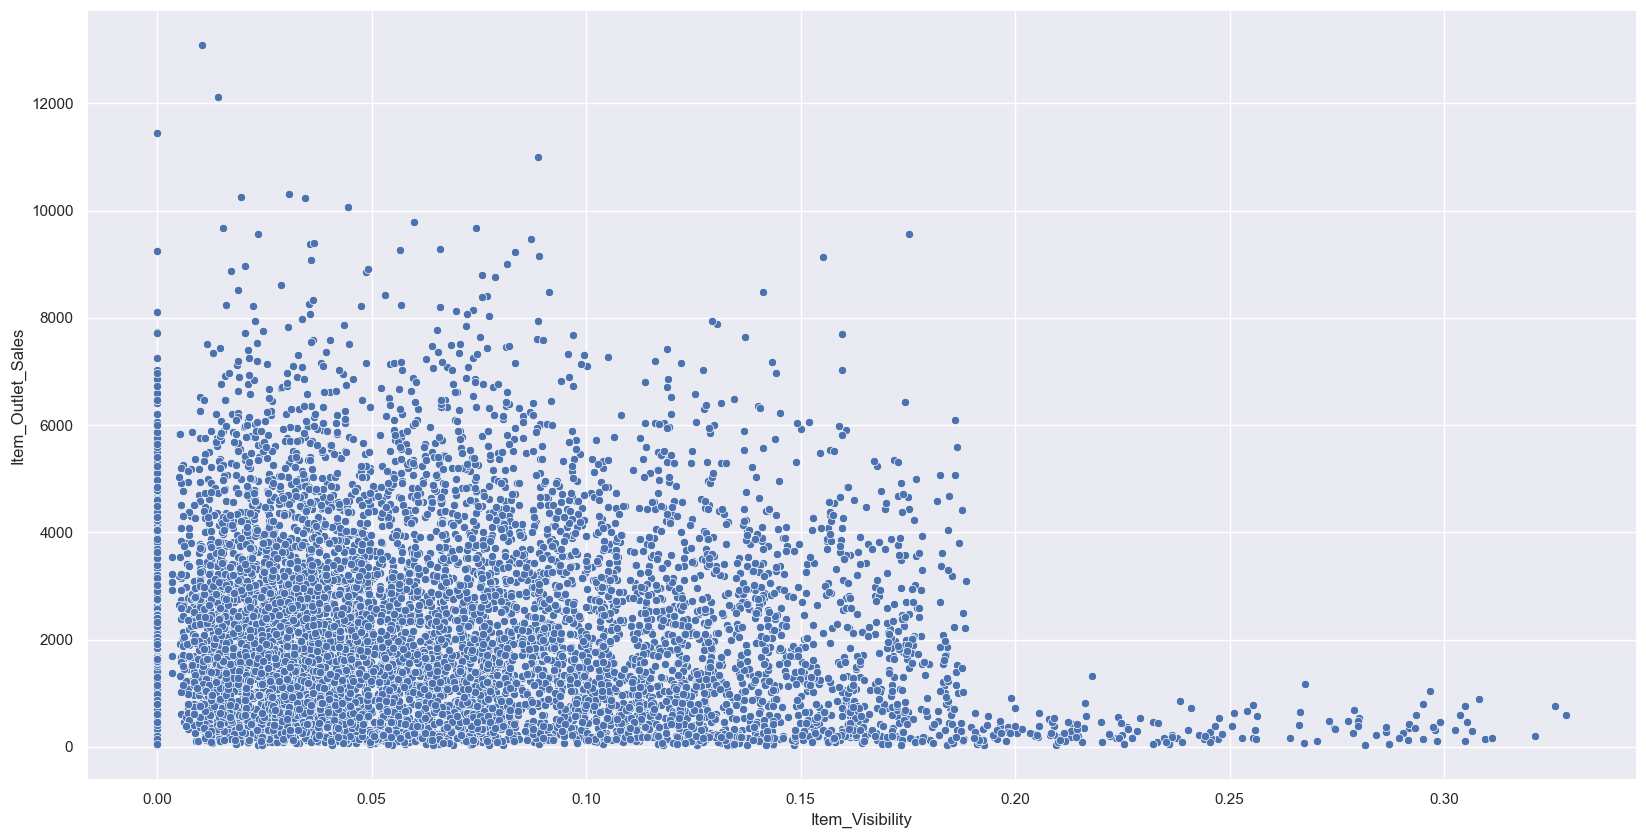

In [34]:
fig, axes = plt.subplots(ncols=1, figsize=(20,10))
sns.scatterplot(data=Sales_P, x='Item_Visibility', y= 'Item_Outlet_Sales')

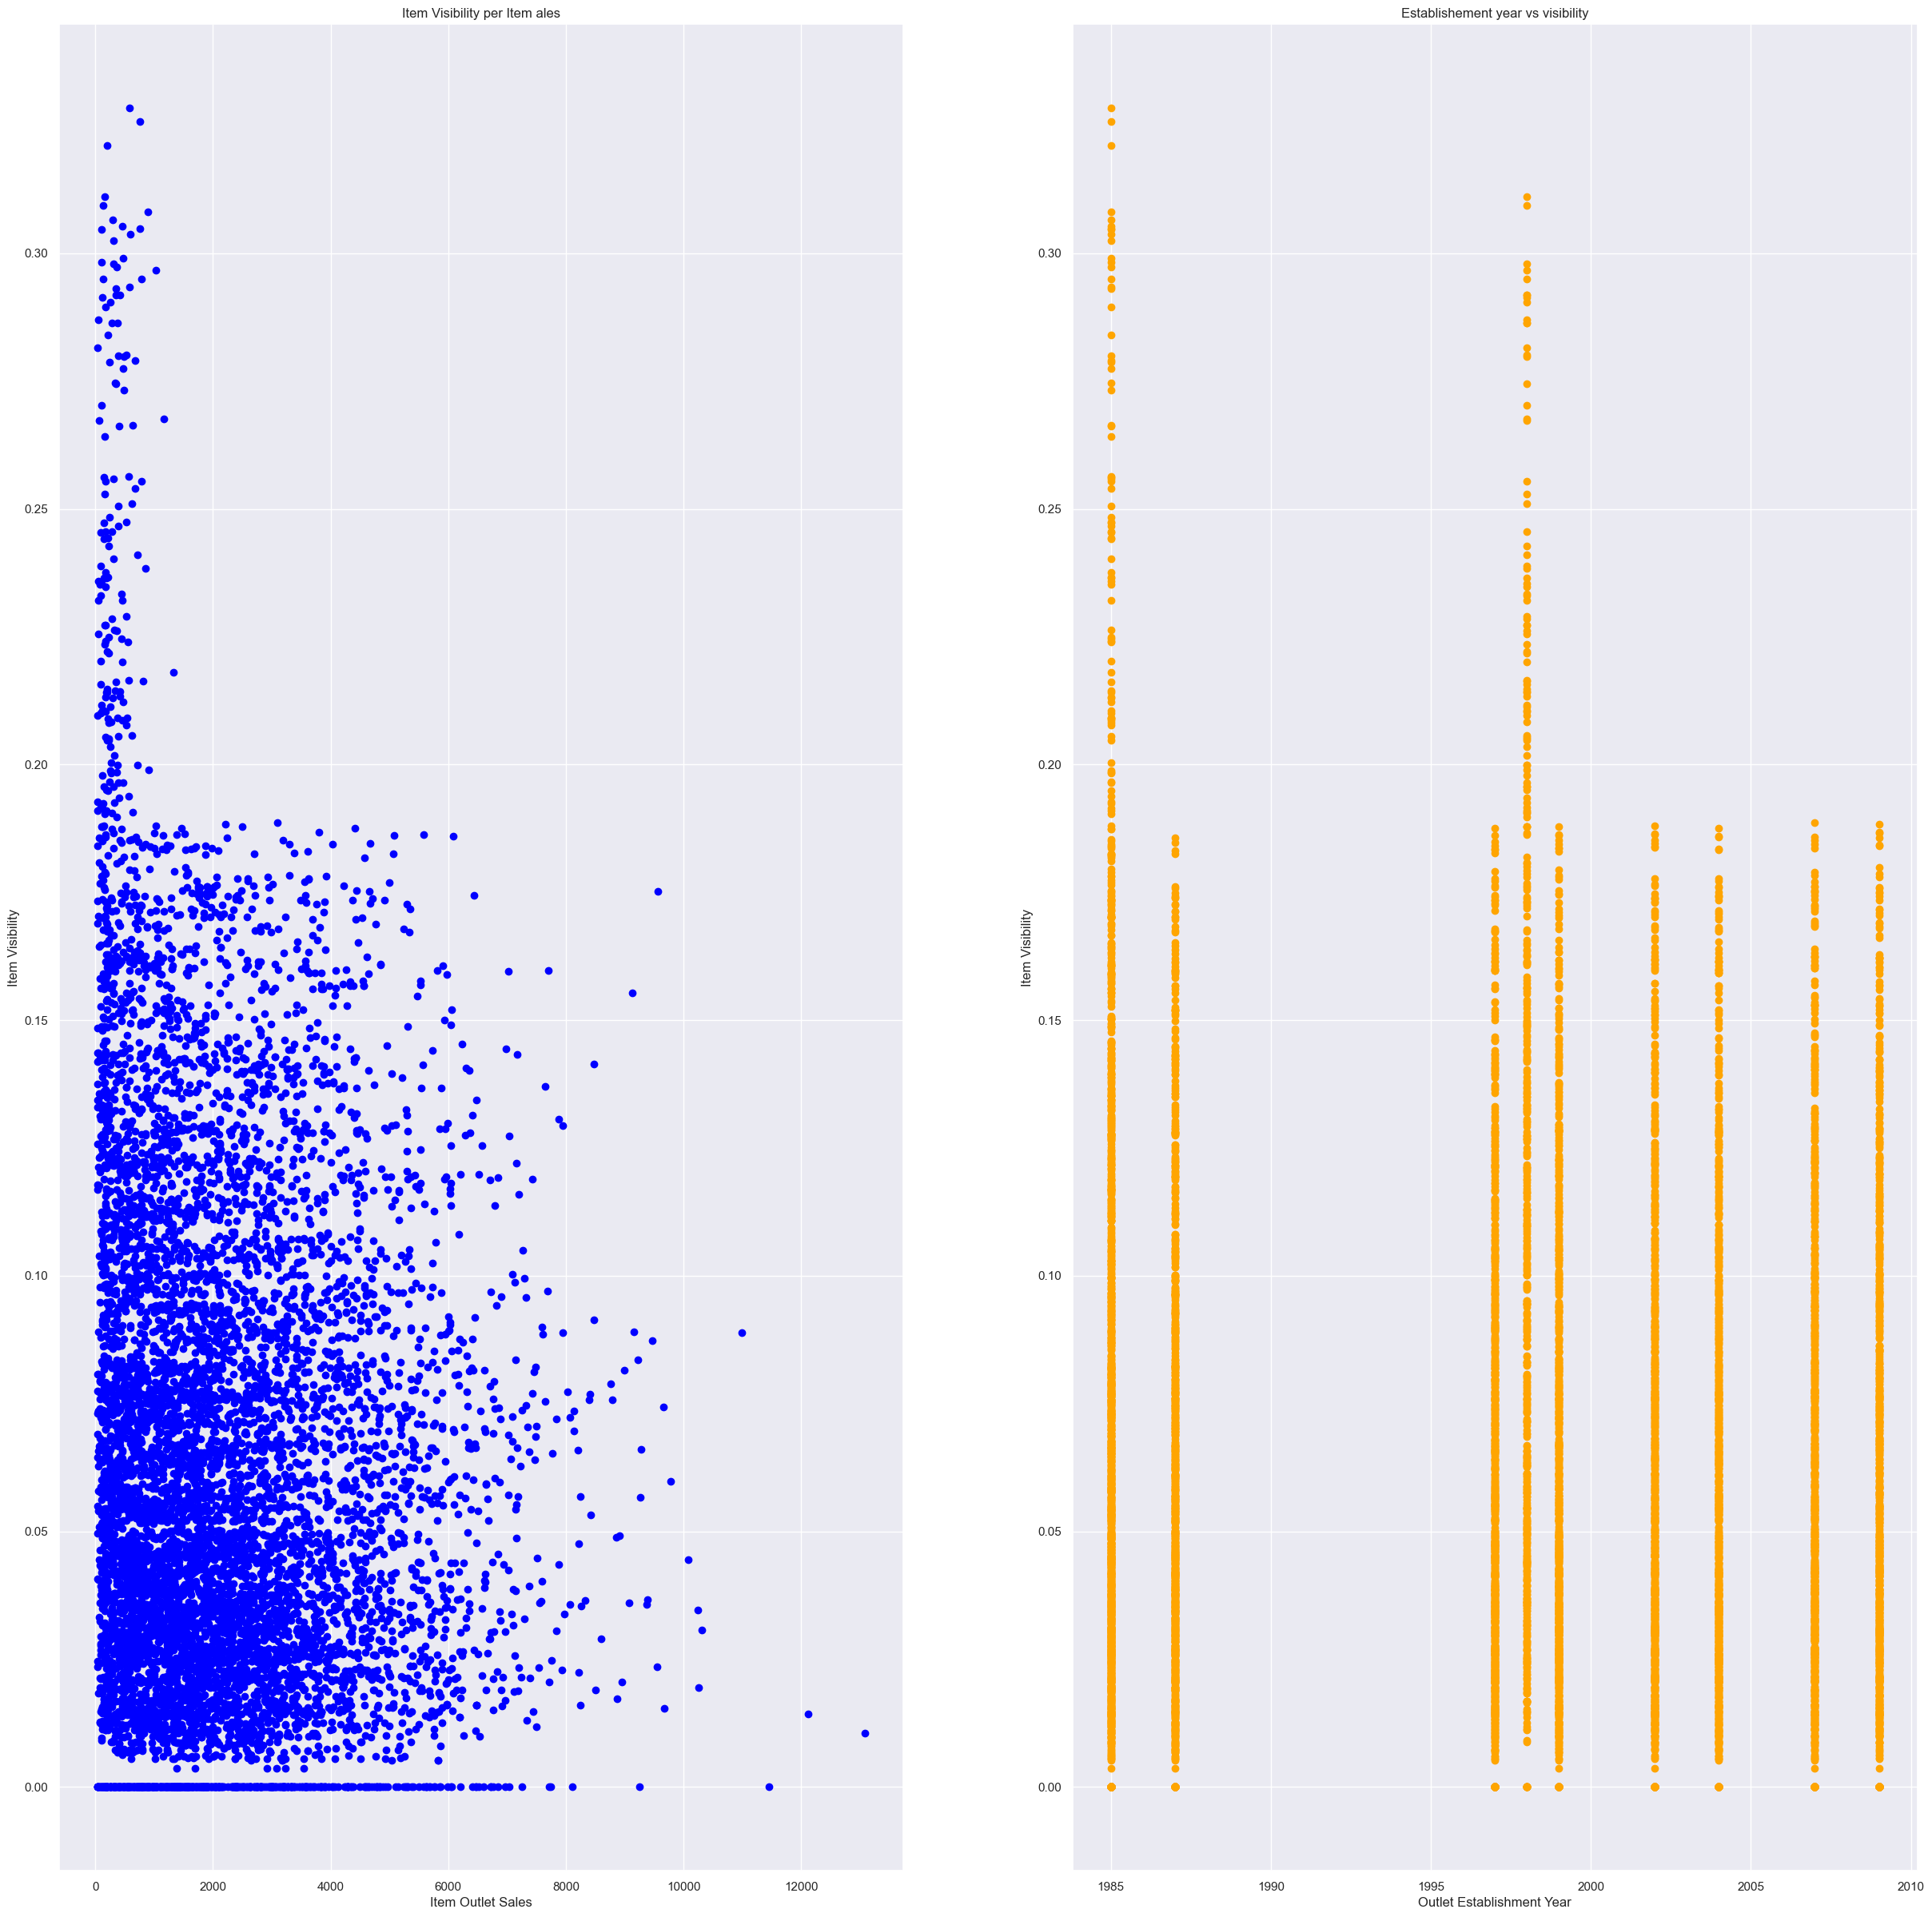

In [35]:
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (30,30))
# Subplot 1 
axes[0].scatter(Sales_P['Item_Outlet_Sales'], Sales_P['Item_Visibility'], color = 'blue')
axes[0].set_title('Item Visibility per Item ales', fontsize = 12)
axes[0].set_ylabel("Item Visibility")
axes[0].set_xlabel("Item Outlet Sales")
# Subplot 2
axes[1].scatter(Sales_P['Outlet_Establishment_Year'], Sales_P['Item_Visibility'], color = 'orange')
axes[1].set_title('Establishement year vs visibility', fontsize = 12)
axes[1].set_ylabel("Item Visibility")
axes[1].set_xlabel("Outlet Establishment Year");

# Revisiting Part 1

## Coefficients with Linear Regression 

In [36]:
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df,y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 0.94	RMSE= 426.02
Test Data:	R^2= 0.56	RMSE= 1168.95


In [37]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False):
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
        
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
        
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [38]:
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

Training Data:	R^2= 0.56	RMSE= 1114.98
Test Data:	R^2= 0.56	RMSE= 1164.41


In [39]:
# lin_reg.coef_
coefs= lin_reg.coef_

In [40]:
features = lin_reg.feature_names_in_
features

coefs = pd.Series(coefs, index=features)
coefs.loc['intercept'] = lin_reg.intercept_
coefs

Item_Weight                            1.067856
Item_Fat_Content                      31.376589
Item_Visibility                     -276.611557
Item_MRP                              15.601944
Outlet_Establishment_Year             36.382100
Item_Type_Baking Goods                 8.977393
Item_Type_Breads                      -4.092190
Item_Type_Breakfast                   69.884397
Item_Type_Canned                      22.600329
Item_Type_Dairy                      -48.843381
Item_Type_Frozen Foods                -5.407801
Item_Type_Fruits and Vegetables       16.173621
Item_Type_Hard Drinks                 49.135252
Item_Type_Health and Hygiene         -41.499603
Item_Type_Household                  -68.642003
Item_Type_Meat                       -15.912070
Item_Type_Others                      17.607098
Item_Type_Seafood                     98.500490
Item_Type_Snack Foods                -11.702918
Item_Type_Soft Drinks               -117.855877
Item_Type_Starchy Foods               31

In [41]:
## Testing our function with intercept=True
ax= plot_coeffs(coefs,top_n=3, intercept=True)

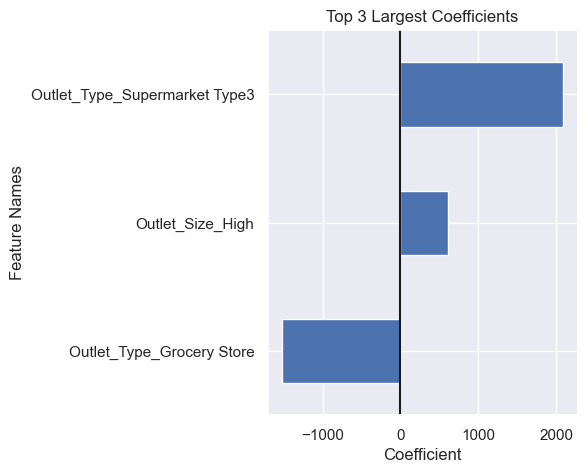

In [42]:
## Testing our function with intercept=False (the default)
ax= plot_coeffs(coefs,top_n=3)

In [43]:
lin_reg_ax = ax.get_figure()

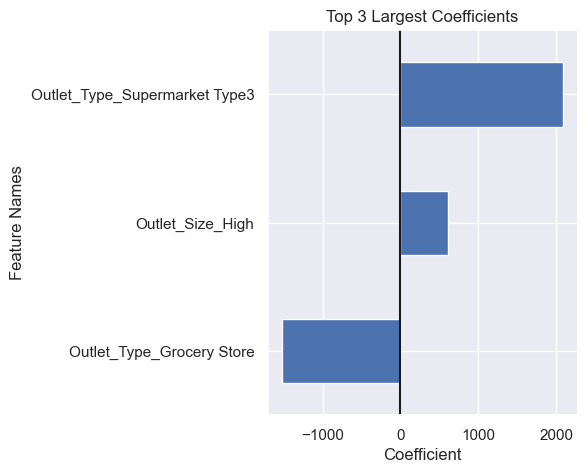

In [44]:
lin_reg_ax

### The coefficients show that the sale of items is dependent of the store type with supermarkets having a positive coefficients and grocery store type having a negative effect on sales. The outlet size is the the third feature to sales amounts.

## Decision Tree Important features

In [45]:
def evaluate_regression(model, X_train,y_train, X_test, y_test):
    """Evaluates a scikit learn regression model using r-squared and RMSE"""

    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train,
                                            squared=False)

    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")


    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test,
                                            squared=False)

    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

reg_tree = DecisionTreeRegressor(random_state= SEED)
dec_pipe = make_pipeline(preprocessor, reg_tree)
dec_pipe.fit(X_train_df,y_train)
evaluate_regression(reg_tree, X_train_df, y_train, X_test_df, y_test)

Training Data:	R^2= 1.00	RMSE= 0.00
Test Data:	R^2= 0.17	RMSE= 1598.17


C:\Users\miran\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
C:\Users\miran\anaconda3\envs\dojo-env\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [46]:
feature_names = preprocessor.get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Type_Baking Goods',
       'Item_Type_Breads', 'Item_Type_Breakfast', 'Item_Type_Canned',
       'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household',
       'Item_Type_Meat', 'Item_Type_Others', 'Item_Type_Seafood',
       'Item_Type_Snack Foods', 'Item_Type_Soft Drinks',
       'Item_Type_Starchy Foods', 'Outlet_Size_High',
       'Outlet_Size_MISSING', 'Outlet_Size_Medium', 'Outlet_Size_Small',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_Location_Type_Tier 3', 'Outlet_Type_Grocery Store',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [47]:
## extract the importances
reg.feature_importances_

array([0.05372124, 0.00811855, 0.09958129, 0.4473363 , 0.03616311,
       0.00459349, 0.00296595, 0.00245869, 0.00422195, 0.00561963,
       0.00584219, 0.00846818, 0.00294891, 0.00437763, 0.00627337,
       0.00371361, 0.00159857, 0.00141995, 0.00811145, 0.00425431,
       0.00291471, 0.00215273, 0.00512804, 0.00461359, 0.00671429,
       0.0044314 , 0.00337032, 0.00315576, 0.19675819, 0.00219971,
       0.00167352, 0.05509939])

In [48]:
## checking the number of feature importances matches the # of columns
print(len(reg.feature_importances_))
print(len(X_train_df.columns))
len(reg.feature_importances_)== len(X_train_df.columns)

32
32


True

In [49]:
## saving the feature importances
importances = pd.Series(reg.feature_importances_, index= feature_names,
                        name= 'Feature Importances')
importances

Item_Weight                        0.053721
Item_Fat_Content                   0.008119
Item_Visibility                    0.099581
Item_MRP                           0.447336
Outlet_Establishment_Year          0.036163
Item_Type_Baking Goods             0.004593
Item_Type_Breads                   0.002966
Item_Type_Breakfast                0.002459
Item_Type_Canned                   0.004222
Item_Type_Dairy                    0.005620
Item_Type_Frozen Foods             0.005842
Item_Type_Fruits and Vegetables    0.008468
Item_Type_Hard Drinks              0.002949
Item_Type_Health and Hygiene       0.004378
Item_Type_Household                0.006273
Item_Type_Meat                     0.003714
Item_Type_Others                   0.001599
Item_Type_Seafood                  0.001420
Item_Type_Snack Foods              0.008111
Item_Type_Soft Drinks              0.004254
Item_Type_Starchy Foods            0.002915
Outlet_Size_High                   0.002153
Outlet_Size_MISSING             

In [50]:
## saving the feature importances sorted from smallest to largest (ascending=False)
sorted_importance = importances.sort_values()
sorted_importance

Item_Type_Seafood                  0.001420
Item_Type_Others                   0.001599
Outlet_Type_Supermarket Type2      0.001674
Outlet_Size_High                   0.002153
Outlet_Type_Supermarket Type1      0.002200
Item_Type_Breakfast                0.002459
Item_Type_Starchy Foods            0.002915
Item_Type_Hard Drinks              0.002949
Item_Type_Breads                   0.002966
Outlet_Location_Type_Tier 3        0.003156
Outlet_Location_Type_Tier 2        0.003370
Item_Type_Meat                     0.003714
Item_Type_Canned                   0.004222
Item_Type_Soft Drinks              0.004254
Item_Type_Health and Hygiene       0.004378
Outlet_Location_Type_Tier 1        0.004431
Item_Type_Baking Goods             0.004593
Outlet_Size_Medium                 0.004614
Outlet_Size_MISSING                0.005128
Item_Type_Dairy                    0.005620
Item_Type_Frozen Foods             0.005842
Item_Type_Household                0.006273
Outlet_Size_Small               

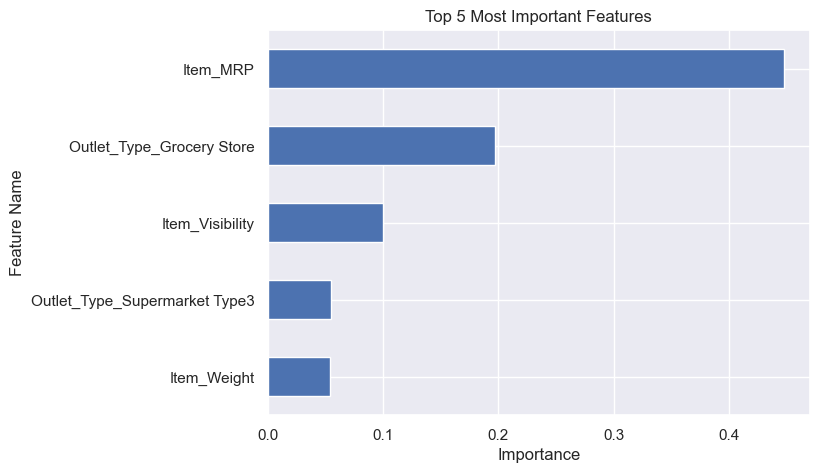

In [51]:
# plotting top 5 importances
ax = sorted_importance.tail(5).plot(kind='barh',
                                     figsize=(7,5),
                                     )

ax.set(xlabel='Importance',
       ylabel='Feature Name',
       title= 'Top 5 Most Important Features');

fig_dc = plt.gcf()

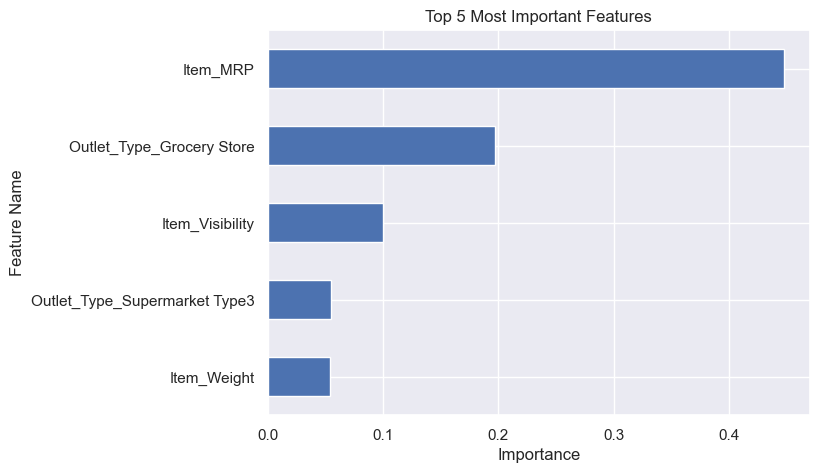

In [52]:
fig_dc

### The decision tree has a major importance of Item_MRP which after being informed of what it means, I do agree that individuals will look at a price and decide on purchasing or not. Grovery store types are also a important feature with Item_visibility, supermarket types and item weight folling right behind.

## Serialize Your Best Models with Joblib

In [53]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train_df,
         'y_train':y_train,
         'X_test':X_test_df,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg,
          'DecisionTreeRegressor':reg_tree
         }

In [54]:
folder = "Models/"
os.makedirs(folder, exist_ok=True)

In [55]:
fname = folder+'best-models-unscaled'
joblib.dump(export, fname)

['Models/best-models-unscaled']

In [56]:
loaded = joblib.load(fname)
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'DecisionTreeRegressor'])

# Revisited Part 2

In [57]:
def evaluate_regression(model, X_train,y_train, X_test, y_test,for_slides=True): 
    """Evaluates a scikit learn regression model using r-squared and RMSE
    FOR SLIDES VERS DOES MULTIPLE PRINT STATEMENTS FOR VERTICAL DISPLAY OF INFO"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    mae_train = metrics.mean_absolute_error(y_train, y_pred_train)
    

    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    mae_test = metrics.mean_absolute_error(y_test, y_pred_test)
    
    if for_slides:
        df_version =[['Split','R^2','MAE','RMSE']]
        df_version.append(['Train',r2_train, mae_train, rmse_train])
        df_version.append(['Test',r2_test, mae_test, rmse_test])
        df_results = pd.DataFrame(df_version[1:], columns=df_version[0])
        df_results = df_results.round(2)
        display(df_results.style.hide(axis='index').format(precision=2, thousands=','))
        
    else: 
        print(f"Training Data:\tR^2 = {r2_train:,.2f}\tRMSE = {rmse_train:,.2f}\tMAE = {mae_train:,.2f}")
        print(f"Test Data:\tR^2 = {r2_test:,.2f}\tRMSE = {rmse_test:,.2f}\tMAE = {mae_test:,.2f}")

def get_coefficients(lin_reg):
    coeffs = pd.Series(lin_reg.coef_, index= lin_reg.feature_names_in_)
    coeffs.loc['intercept'] = lin_reg.intercept_
    return coeffs

def plot_coefficients(coeffs, sort_values=True, top_n=None, figsize=(6,4),
                     title="Linear Regression Coefficients", xlabel='Coefficient'):
    """Plots a Series of coefficients as horizotal bar chart, with option to sort
    and to only keep top_n coefficients"""
        
    if top_n is not None:
        top_n = coeffs.abs().rank().sort_values(ascending=False).head(top_n)
        coeffs = coeffs.loc[top_n.index]
        
    if sort_values:
        coeffs = coeffs.sort_values()

        
        
    ax = coeffs.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax


def get_importances(rf_reg):
    importances = pd.Series(rf_reg.feature_importances_, index= rf_reg.feature_names_in_)
    return importances


def plot_importances(importances, sort_values=True, top_n=None, figsize=(6,4),
                     title="Feature Importance", xlabel='Importance'):
    if sort_values:
        importances = importances.sort_values()
        
    if top_n is not None:
        importances = importances.tail(top_n)
        
        
    ax = importances.plot(kind='barh', figsize=figsize)
    ax.axvline(0, color='k')
    ax.set(xlabel=xlabel, title=title);
    plt.show()
    return ax

## Load Your Saved Joblib File

In [58]:
## Load the joblib file stored in the models folder
fname = "Models/best-models-unscaled"

loaded = joblib.load(fname)
# Preview the contents of the loaded joblib objects
loaded.keys()

dict_keys(['X_train', 'y_train', 'X_test', 'y_test', 'preprocessor', 'LinearRegression', 'DecisionTreeRegressor'])

In [59]:
## Saving the loaded objects as separate varaibles
X_train = loaded['X_train']
X_test = loaded['X_test']
y_train = loaded['y_train']
y_test = loaded['y_test']

preprocessor = loaded['preprocessor']
lin_reg_final = loaded['LinearRegression']
dc_reg = loaded['DecisionTreeRegressor']

X_train.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
8269        7.220               1.0         0.064142   61.2510   
7604        6.135               0.0         0.079294  111.2860   
2762       12.150               0.0         0.028593  151.0708   
6464        5.945               0.0         0.093009  127.8652   
4707       18.200               1.0         0.066285  247.2092   

      Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
8269                     1998.0                     1.0               0.0   
7604                     2009.0                     0.0               0.0   
2762                     2004.0                     0.0               0.0   
6464                     2004.0                     0.0               0.0   
4707                     2004.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
8269                  0.0               0.0              0.0   
7604                  0.0               0.0              0.0   
2762                  0.0               0.0              0.0   
6464                  0.0               0.0              0.0   
4707                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
8269                     0.0                              0.0   
7604                     0.0                              0.0   
2762                     0.0                              0.0   
6464                     0.0                              0.0   
4707                     0.0                              1.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
8269                    0.0                           0.0   
7604                    0.0                           0.0   
2762                    0.0                           0.0   
6464                    0.0                           0.0   
4707                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
8269                  0.0             0.0               0.0   
7604                  0.0             0.0               0.0   
2762                  1.0             0.0               0.0   
6464                  1.0             0.0               0.0   
4707                  0.0             0.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_Type_Soft Drinks  \
8269                0.0                    0.0                    0.0   
7604                0.0                    0.0                    1.0   
2762                0.0                    0.0                    0.0   
6464                0.0                    0.0                    0.0   
4707                0.0                    0.0                    0.0   

      Item_Type_Starchy Foods  Outlet_Size_High  Outlet_Size_MISSING  \
8269                      0.0               0.0                  1.0   
7604                      0.0               0.0                  0.0   
2762                      0.0               0.0                  0.0   
6464                      0.0               0.0                  0.0   
4707                      0.0               0.0                  0.0   

      Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 1  \
8269                 0.0                0.0                          0.0   
7604                 1.0                0.0                          0.0   
2762                 0.0                1.0                          0.0   
6464                 0.0                1.0                          0.0   
4707                 0.0                1.0                          0.0   

      Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
8269                          0.0                          1.0   
7604                          0.0                          1.0   
2762                          1.0                          0.0   
6464                          1

## Explaining Models with Shap

In [60]:
# Import and init shap
import shap
shap.initjs()

In [61]:
# Take a sample of the training data (nsampel=500, use random_state=SEED)
X_shap = shap.sample(X_train,nsamples = 500,random_state=SEED)
y_shap = y_train.loc[X_shap.index]
X_shap.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
4469         7.72               1.0         0.074669   76.3986   
4438         5.11               0.0         0.034868  163.8210   
366          8.05               1.0         0.078386  256.4646   
2219         8.76               0.0         0.050131  128.3336   
6080         6.59               0.0         0.176748   82.7908   

      Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
4469                     1987.0                     0.0               1.0   
4438                     2004.0                     0.0               0.0   
366                      2004.0                     0.0               0.0   
2219                     1999.0                     0.0               0.0   
6080                     1998.0                     0.0               0.0   

      Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
4469                  0.0               0.0              0.0   
4438                  0.0               0.0              0.0   
366                   0.0               0.0              0.0   
2219                  0.0               0.0              0.0   
6080                  0.0               0.0              0.0   

      Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
4469                     0.0                              0.0   
4438                     0.0                              0.0   
366                      0.0                              1.0   
2219                     0.0                              0.0   
6080                     0.0                              1.0   

      Item_Type_Hard Drinks  Item_Type_Health and Hygiene  \
4469                    0.0                           0.0   
4438                    0.0                           0.0   
366                     0.0                           0.0   
2219                    0.0                           1.0   
6080                    0.0                           0.0   

      Item_Type_Household  Item_Type_Meat  Item_Type_Others  \
4469                  0.0             0.0               0.0   
4438                  1.0             0.0               0.0   
366                   0.0             0.0               0.0   
2219                  0.0             0.0               0.0   
6080                  0.0             0.0               0.0   

      Item_Type_Seafood  Item_Type_Snack Foods  Item_Type_Soft Drinks  \
4469                0.0                    0.0                    0.0   
4438                0.0                    0.0                    0.0   
366                 0.0                    0.0                    0.0   
2219                0.0                    0.0                    0.0   
6080                0.0                    0.0                    0.0   

      Item_Type_Starchy Foods  Outlet_Size_High  Outlet_Size_MISSING  \
4469                      0.0               1.0                  0.0   
4438                      0.0               0.0                  0.0   
366                       0.0               0.0                  0.0   
2219                      0.0               0.0                  0.0   
6080                      0.0               0.0                  1.0   

      Outlet_Size_Medium  Outlet_Size_Small  Outlet_Location_Type_Tier 1  \
4469                 0.0                0.0                          0.0   
4438                 0.0                1.0                          0.0   
366                  0.0                1.0                          0.0   
2219                 1.0                0.0                          1.0   
6080                 0.0                0.0                          0.0   

      Outlet_Location_Type_Tier 2  Outlet_Location_Type_Tier 3  \
4469                          0.0                          1.0   
4438                          1.0                          0.0   
366                           1.0                          0.0   
2219                          0

In [62]:
# Instantiate a Model Explainer with the model
dc_explainer = shap.Explainer(dc_reg)

## Get shap values from the explainer
dc_shap_values = dc_explainer(X_shap)
dc_shap_values[0]

.values =
array([ 3.86037391e+01,  2.41092092e+02, -8.44488103e+01, -9.30485020e+02,
       -2.81051532e+01, -1.29553180e+00,  6.60857185e+00, -1.65504562e-01,
       -1.37572141e+01, -1.68521319e+00, -9.15146911e-01, -5.71495864e+00,
       -2.08381458e+00,  9.24706351e-01,  3.09386591e+01, -4.25029266e-01,
       -2.51386100e-01, -7.67718242e-01,  1.11251455e+01, -1.33597915e+00,
       -2.04006356e+00, -1.90260453e+01, -7.49966223e+01, -3.91447463e+01,
       -8.97326368e+00, -6.56515442e+00,  1.28485417e+00, -1.14265545e+01,
        2.07738817e+02, -1.99806676e+00,  2.66357589e+00, -5.68413743e+01])

.base_values =
array([2153.64301101])

.data =
array([7.7200000e+00, 1.0000000e+00, 7.4669288e-02, 7.6398600e+01,
       1.9870000e+03, 0.0000000e+00, 1.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
       0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
      

In [63]:
## Create an explainer for the lin_reg
linreg_explainer= shap.Explainer(lin_reg_final, X_shap)

## get shap values for linreg
shap_values_linreg = linreg_explainer(X_shap)
shap_values_linreg.shape

(500, 32)

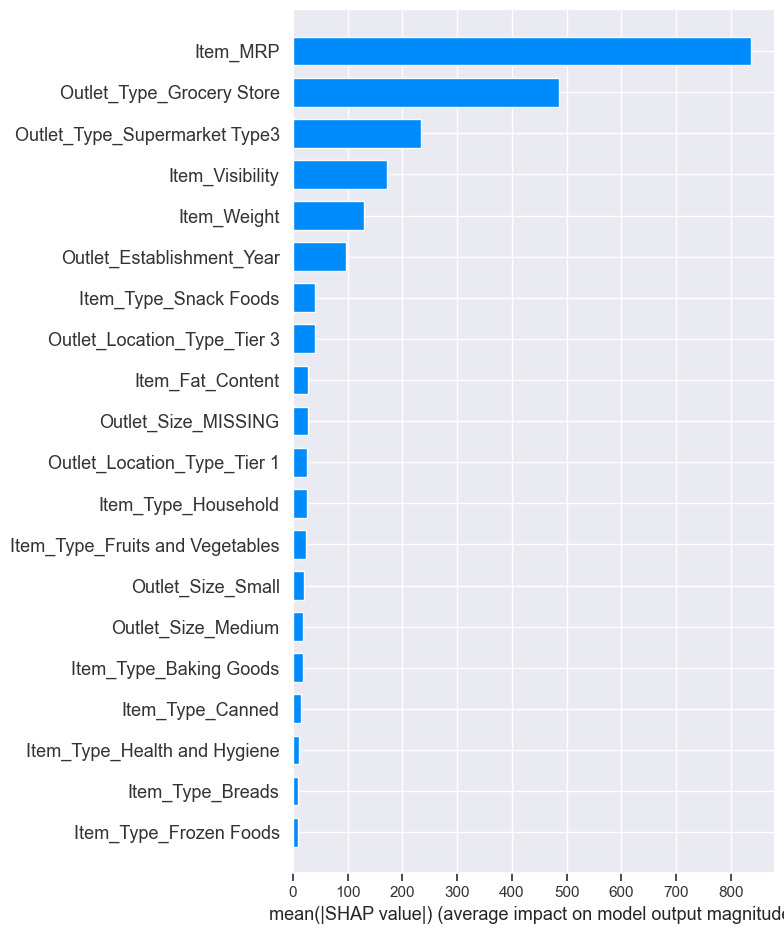

In [64]:
## create a summary plot (bar version)
shap.summary_plot(dc_shap_values, features = X_shap, plot_type='bar')

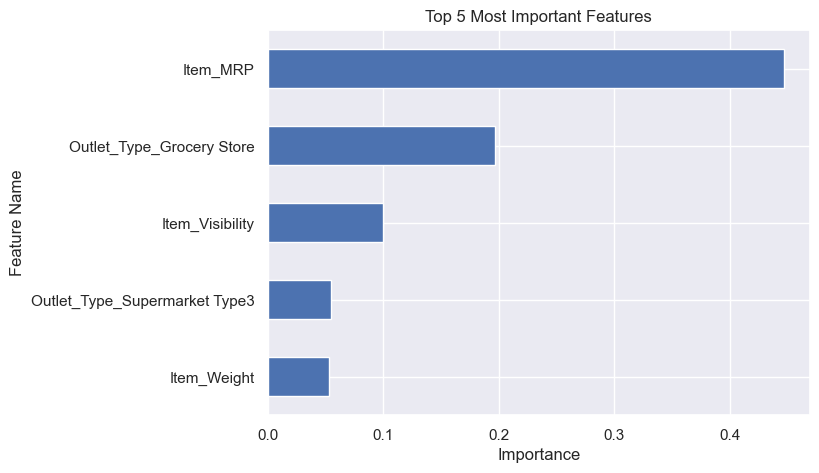

### They show exactly the same information. All the top important features are present in both bar plot.

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


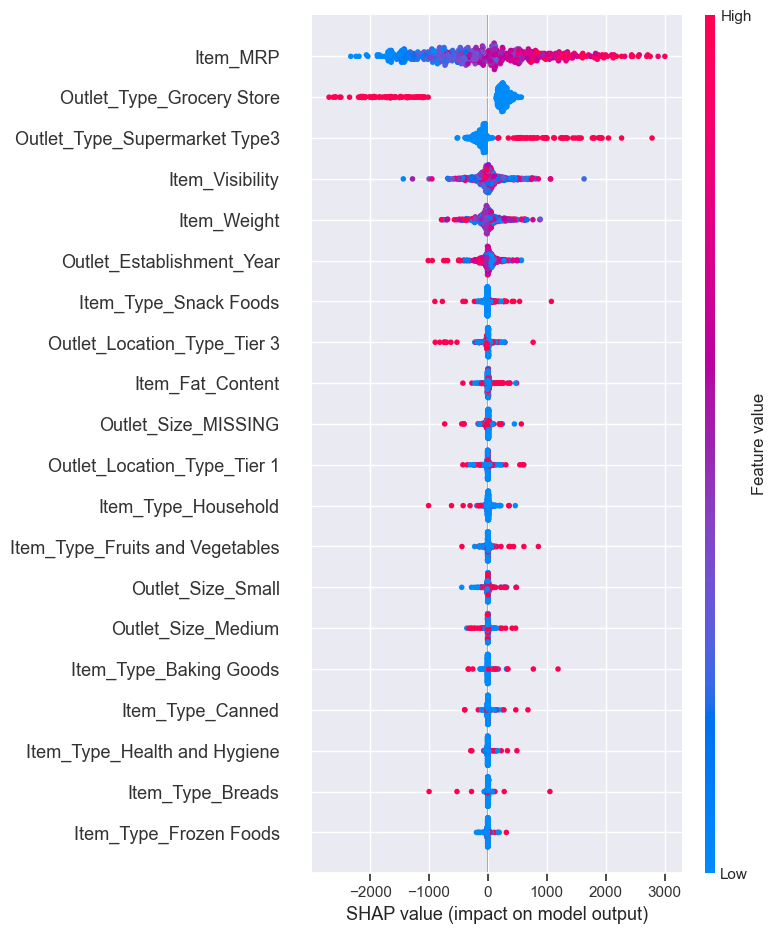

In [65]:
## create a summary plot (dot/default version)
shap.summary_plot(dc_shap_values, features = X_shap)

### The most important features are Item_MRP, Grocery/ Supermarker type stores, Item_Visibility, and Item_Weight. I see that there are other features that have smaller impacts to the sales of the stores.  The newer stores are having a negative affect to sales and super markets type 3 are giving a negative impact all around. 

# Revisited Part 3

## Local Explanation

In [66]:
## Making a vers of shap vars with 0-based integer index 
# so what it matches the index for the shap_vallues
X_shap_local = X_shap.reset_index(drop=True)
y_shap_local = y_shap.reset_index(drop=True)
X_shap_local.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_MRP  \
0         7.72               1.0         0.074669   76.3986   
1         5.11               0.0         0.034868  163.8210   
2         8.05               1.0         0.078386  256.4646   
3         8.76               0.0         0.050131  128.3336   
4         6.59               0.0         0.176748   82.7908   

   Outlet_Establishment_Year  Item_Type_Baking Goods  Item_Type_Breads  \
0                     1987.0                     0.0               1.0   
1                     2004.0                     0.0               0.0   
2                     2004.0                     0.0               0.0   
3                     1999.0                     0.0               0.0   
4                     1998.0                     0.0               0.0   

   Item_Type_Breakfast  Item_Type_Canned  Item_Type_Dairy  \
0                  0.0               0.0              0.0   
1                  0.0               0.0              0.0   
2                  0.0               0.0              0.0   
3                  0.0               0.0              0.0   
4                  0.0               0.0              0.0   

   Item_Type_Frozen Foods  Item_Type_Fruits and Vegetables  \
0                     0.0                              0.0   
1                     0.0                              0.0   
2                     0.0                              1.0   
3                     0.0                              0.0   
4                     0.0                              1.0   

   Item_Type_Hard Drinks  Item_Type_Health and Hygiene  Item_Type_Household  \
0                    0.0                           0.0                  0.0   
1                    0.0                           0.0                  1.0   
2                    0.0                           0.0                  0.0   
3                    0.0                           1.0                  0.0   
4                    0.0                           0.0                  0.0   

   Item_Type_Meat  Item_Type_Others  Item_Type_Seafood  Item_Type_Snack Foods  \
0             0.0               0.0                0.0                    0.0   
1             0.0               0.0                0.0                    0.0   
2             0.0               0.0                0.0                    0.0   
3             0.0               0.0                0.0                    0.0   
4             0.0               0.0                0.0                    0.0   

   Item_Type_Soft Drinks  Item_Type_Starchy Foods  Outlet_Size_High  \
0                    0.0                      0.0               1.0   
1                    0.0                      0.0               0.0   
2                    0.0                      0.0               0.0   
3                    0.0                      0.0               0.0   
4                    0.0                      0.0               0.0   

   Outlet_Size_MISSING  Outlet_Size_Medium  Outlet_Size_Small  \
0                  0.0                 0.0                0.0   
1                  0.0                 0.0                1.0   
2                  0.0                 0.0                1.0   
3                  0.0                 1.0                0.0   
4                  1.0                 0.0                0.0   

   Outlet_Location_Type_Tier 1  Outlet_Location_Type_Tier 2  \
0                          0.0                          0.0   
1                          0.0                          1.0   
2                          0.0                          1.0   
3                          1.0                          0.0   
4                          0.0                          0.0   

   Outlet_Location_Type_Tier 3  Outlet_Type_Grocery Store  \
0                          1.0                        0.0   
1                          0.0                        0.0   
2                          0.0                        0.0   
3                          0.0      

In [67]:
# what is the max/range of Item Visibility
X_shap_local['Item_Visibility'].describe()

count    500.000000
mean       0.068355
std        0.052539
min        0.000000
25%        0.028286
50%        0.055404
75%        0.102788
max        0.293418
Name: Item_Visibility, dtype: float64

In [68]:
## saving the index of the most visibility
item_high_vis = X_shap_local['Item_Visibility'].idxmax()
item_high_vis

271

In [69]:
## saving the index of the most visibility
item_low_vis = X_shap_local['Item_Visibility'].idxmin()
item_low_vis

45

### I choice the feature of Item-Visibility as my high and low example. I believe that the where an item is placed will lead to a bigger selling point.

## Lime

In [70]:
from lime.lime_tabular import LimeTabularExplainer

## Create a lime explainer with X_shap_local with regression as the mode
lime_explainer =LimeTabularExplainer(
    training_data=X_shap_local.values,  
    feature_names=X_shap_local.columns,
   mode='regression'
)
lime_explainer

In [71]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[item_high_vis],
                                      dc_reg.predict)
exp.show_in_notebook()

In [72]:
## Use the lime explainer to explain the selected example used above 
exp = lime_explainer.explain_instance(X_shap_local.loc[item_low_vis],
                                      dc_reg.predict)
exp.show_in_notebook()

### The Lime Explainer has the Outlet type grocery stores having a major negative impact on high visibility items. While low visibility items have a positive impact on grocery type stores. Item MRP is has the same impact on both high and low visibility items I don't see that pricing would change. Everything else has lesser impacts.

### You can see with more visibility a product sells better with less visibility the item has more negatives going on in the Lime Explorer.

In [73]:
shap.force_plot(linreg_explainer.expected_value,shap_values_linreg.values,X_shap_local,)

In [74]:
shap.force_plot(dc_explainer.expected_value,dc_shap_values.values,X_shap_local,)

### I used item_visibility for the force plots on both the decision tree regression and the linear regression to see the effects it presents for sales per store. I like the decision tree plot and think doing it on a random forest would give a better comparison for this part or the assingment.

# I think this gives a clearer look at the data but if I look at a different question the scaled option would better. When we are looking for money it makes more sense not scale it. 

In [1]:
### am I on the right path?